In [1]:
import os
import cv2
from math import inf
from PIL import Image
import torch, torchvision
from torch import nn
from tqdm import tqdm
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

In [2]:
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [3]:
dataset = torchvision.datasets.ImageFolder(root = "./datasets/car_tier", transform = preprocess)

In [4]:
dataset[0]

(tensor([[[-1.5357, -0.7822, -0.4226,  ...,  1.0331,  1.0502,  1.2043],
          [-1.4329, -0.6452, -0.4054,  ...,  0.9303,  1.0673,  1.1187],
          [-1.2445, -0.5424, -0.2171,  ...,  0.9474,  1.0502,  1.0673],
          ...,
          [-0.6623, -0.8164, -1.0219,  ..., -0.6965, -0.6965, -0.6281],
          [-0.5082, -0.8507, -0.9534,  ..., -0.6794, -0.6623, -0.6452],
          [-0.5767, -0.9192, -0.9192,  ..., -0.6965, -0.6623, -0.5938]],
 
         [[-1.5280, -0.7577, -0.3901,  ...,  0.9755,  0.9755,  1.1331],
          [-1.4230, -0.6176, -0.3725,  ...,  0.8704,  0.9930,  1.0455],
          [-1.2304, -0.5126, -0.1800,  ...,  0.8880,  0.9755,  0.9930],
          ...,
          [-0.6702, -0.8452, -1.0728,  ..., -0.8277, -0.8277, -0.7927],
          [-0.5476, -0.8978, -1.0203,  ..., -0.8102, -0.7927, -0.8102],
          [-0.6176, -0.9678, -0.9853,  ..., -0.8277, -0.7927, -0.7577]],
 
         [[-1.3513, -0.5844, -0.2358,  ...,  0.8971,  0.9145,  1.0714],
          [-1.2467, -0.4624,

In [5]:
dataset.class_to_idx

{'defective': 0, 'good': 1}

In [6]:
dataset[100]

(tensor([[[-0.2856, -0.3883, -0.7822,  ..., -1.4843, -0.7822, -0.1314],
          [-0.4568, -0.5253, -0.8678,  ..., -1.6727, -0.7993,  0.0056],
          [-0.3198, -0.6794, -0.9534,  ..., -1.6213, -0.6794,  0.1939],
          ...,
          [-0.7308, -0.9705, -1.0904,  ..., -1.2103, -1.1075, -1.0219],
          [-0.7650, -1.1075, -1.1075,  ..., -1.4329, -1.3815, -1.3302],
          [-0.8335, -1.0562, -0.7479,  ..., -1.4672, -1.4500, -1.4158]],
 
         [[-0.0574, -0.1625, -0.5651,  ..., -1.1078, -0.3725,  0.3277],
          [-0.2500, -0.3200, -0.6702,  ..., -1.3179, -0.4076,  0.4503],
          [-0.1099, -0.4776, -0.7577,  ..., -1.2654, -0.2850,  0.6254],
          ...,
          [-0.7752, -1.0203, -1.1429,  ..., -1.0728, -0.9853, -0.8978],
          [-0.8102, -1.1604, -1.1604,  ..., -1.3179, -1.2654, -1.2129],
          [-0.8803, -1.1078, -0.7927,  ..., -1.3529, -1.3354, -1.3004]],
 
         [[ 0.1651,  0.0605, -0.3404,  ..., -1.0027, -0.2881,  0.4439],
          [ 0.0082, -0.0615,

In [7]:
train_data, test_data = random_split(dataset, [0.8, 0.2])

In [8]:
train_dataloader = DataLoader(train_data, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=128, shuffle=True)

In [9]:
print(len(train_dataloader), len(test_dataloader))

12 3


In [10]:
resnet_model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V1)
resnet_model.fc = nn.Identity()
for param in resnet_model.parameters():
    param.requires_grad = False
resnet_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [11]:
fc_model = nn.Sequential(
    nn.Linear(2048, 1024),
    nn.ReLU(),
    nn.Linear(1024, 1)
)

In [12]:
model = nn.Sequential(
    resnet_model,
    fc_model
)

In [13]:
model

Sequential(
  (0): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0)

In [14]:
for x, y in train_dataloader:
    outputs = model(x)
    print(outputs.shape)
    break

torch.Size([128, 1])


In [15]:
optimizer = torch.optim.Adam(fc_model.parameters(), lr=0.001)
loss_fn = nn.BCEWithLogitsLoss()

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [17]:
model.to(device)

Sequential(
  (0): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0)

In [18]:
early_stopping = 0
old_loss = inf
for i in range(10):
    print(f"----- EPOCH: {i+1} --------")
    training_loss = 0
    train_accuracy = 0
    train_sum = 0
    model.train()
    resnet_model.eval()
    for x, y in tqdm(train_dataloader):
        x = x.to(device)
        y = y.to(device).type(torch.float32).reshape(-1, 1)
        optimizer.zero_grad()
        outputs = model(x)
        predictions = torch.sigmoid(outputs) > 0.5
        loss = loss_fn(outputs, y)
        loss.backward()
        optimizer.step()  
        training_loss += loss.item()
        train_accuracy += (predictions == y).sum().item()
        train_sum += y.size(0)
    if training_loss < old_loss:
        old_loss = training_loss
        early_stopping = 0
    else:
        early_stopping += 1
    if early_stopping > 3:
        print("Early stopping triggered")
        break
    print("Training loss is : ", training_loss / len(train_dataloader), " ", "Training_Accuracy: ", train_accuracy / train_sum)

    val_loss = 0
    val_accuracy = 0
    val_sum = 0
    model.eval()
    with torch.no_grad():
        for x, y in tqdm(test_dataloader):
            x = x.to(device)
            y = y.to(device).type(torch.float32).reshape(-1, 1)
            outputs = model(x)
            predictions = torch.sigmoid(outputs) > 0.5
            loss = loss_fn(outputs, y)
            val_loss += loss.item()
            val_accuracy += (predictions == y).sum().item()
            val_sum += y.size(0)
    print("Validation Loss: ", val_loss / len(test_dataloader), " ", "Validation_Accuracy: ", val_accuracy / val_sum)

----- EPOCH: 1 --------


100%|██████████████████████| 12/12 [01:36<00:00,  8.06s/it]


Training loss is :  0.49362388129035634   Training_Accuracy:  0.7535353535353535


100%|████████████████████████| 3/3 [00:22<00:00,  7.43s/it]


Validation Loss:  0.29290781418482464   Validation_Accuracy:  0.8840970350404312
----- EPOCH: 2 --------


100%|██████████████████████| 12/12 [01:44<00:00,  8.70s/it]


Training loss is :  0.24613095819950104   Training_Accuracy:  0.8929292929292929


100%|████████████████████████| 3/3 [00:25<00:00,  8.33s/it]


Validation Loss:  0.22376489639282227   Validation_Accuracy:  0.8975741239892183
----- EPOCH: 3 --------


100%|██████████████████████| 12/12 [01:46<00:00,  8.87s/it]


Training loss is :  0.20688790455460548   Training_Accuracy:  0.9198653198653198


100%|████████████████████████| 3/3 [00:25<00:00,  8.45s/it]


Validation Loss:  0.19156853357950845   Validation_Accuracy:  0.9110512129380054
----- EPOCH: 4 --------


100%|██████████████████████| 12/12 [01:50<00:00,  9.23s/it]


Training loss is :  0.17728449031710625   Training_Accuracy:  0.9265993265993266


100%|████████████████████████| 3/3 [00:25<00:00,  8.45s/it]


Validation Loss:  0.1931529442469279   Validation_Accuracy:  0.9245283018867925
----- EPOCH: 5 --------


100%|██████████████████████| 12/12 [01:50<00:00,  9.20s/it]


Training loss is :  0.1584680713713169   Training_Accuracy:  0.94006734006734


100%|████████████████████████| 3/3 [00:25<00:00,  8.58s/it]


Validation Loss:  0.1624146948258082   Validation_Accuracy:  0.9353099730458221
----- EPOCH: 6 --------


100%|██████████████████████| 12/12 [01:47<00:00,  8.96s/it]


Training loss is :  0.1561749658236901   Training_Accuracy:  0.9373737373737374


100%|████████████████████████| 3/3 [00:26<00:00,  8.95s/it]


Validation Loss:  0.2111103187004725   Validation_Accuracy:  0.9083557951482479
----- EPOCH: 7 --------


100%|██████████████████████| 12/12 [01:52<00:00,  9.37s/it]


Training loss is :  0.17573152606685957   Training_Accuracy:  0.9205387205387205


100%|████████████████████████| 3/3 [00:25<00:00,  8.59s/it]


Validation Loss:  0.1479358822107315   Validation_Accuracy:  0.9460916442048517
----- EPOCH: 8 --------


100%|██████████████████████| 12/12 [01:44<00:00,  8.71s/it]


Training loss is :  0.1596969123929739   Training_Accuracy:  0.9353535353535354


100%|████████████████████████| 3/3 [00:23<00:00,  7.88s/it]


Validation Loss:  0.19881314039230347   Validation_Accuracy:  0.9164420485175202
----- EPOCH: 9 --------


100%|██████████████████████| 12/12 [01:42<00:00,  8.56s/it]


Training loss is :  0.13359125331044197   Training_Accuracy:  0.9454545454545454


100%|████████████████████████| 3/3 [00:25<00:00,  8.54s/it]


Validation Loss:  0.16833152621984482   Validation_Accuracy:  0.9326145552560647
----- EPOCH: 10 --------


100%|██████████████████████| 12/12 [01:47<00:00,  8.93s/it]


Training loss is :  0.10381605662405491   Training_Accuracy:  0.9582491582491582


100%|████████████████████████| 3/3 [00:24<00:00,  8.30s/it]

Validation Loss:  0.13211537400881448   Validation_Accuracy:  0.9595687331536388


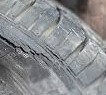

In [19]:
image = Image.open("test/tyre.jpg")
image

In [20]:
img = preprocess(image)
print(img.shape)

torch.Size([3, 224, 224])


In [21]:
img = img.unsqueeze(dim=0)
print(img.shape)

torch.Size([1, 3, 224, 224])


In [23]:
model.eval()
with torch.no_grad():
    outputs = model(img.to(device))
    predictions = torch.sigmoid(outputs)[0]
    print(predictions.item())

0.002393801463767886


In [24]:
image = Image.open("test/tyre1.jpg")
img = preprocess(image).unsqueeze(dim=0)
model.eval()
with torch.no_grad():
    outputs = model(img.to(device))
    predictions = torch.sigmoid(outputs)[0]
    print(predictions.item())

0.027857759967446327


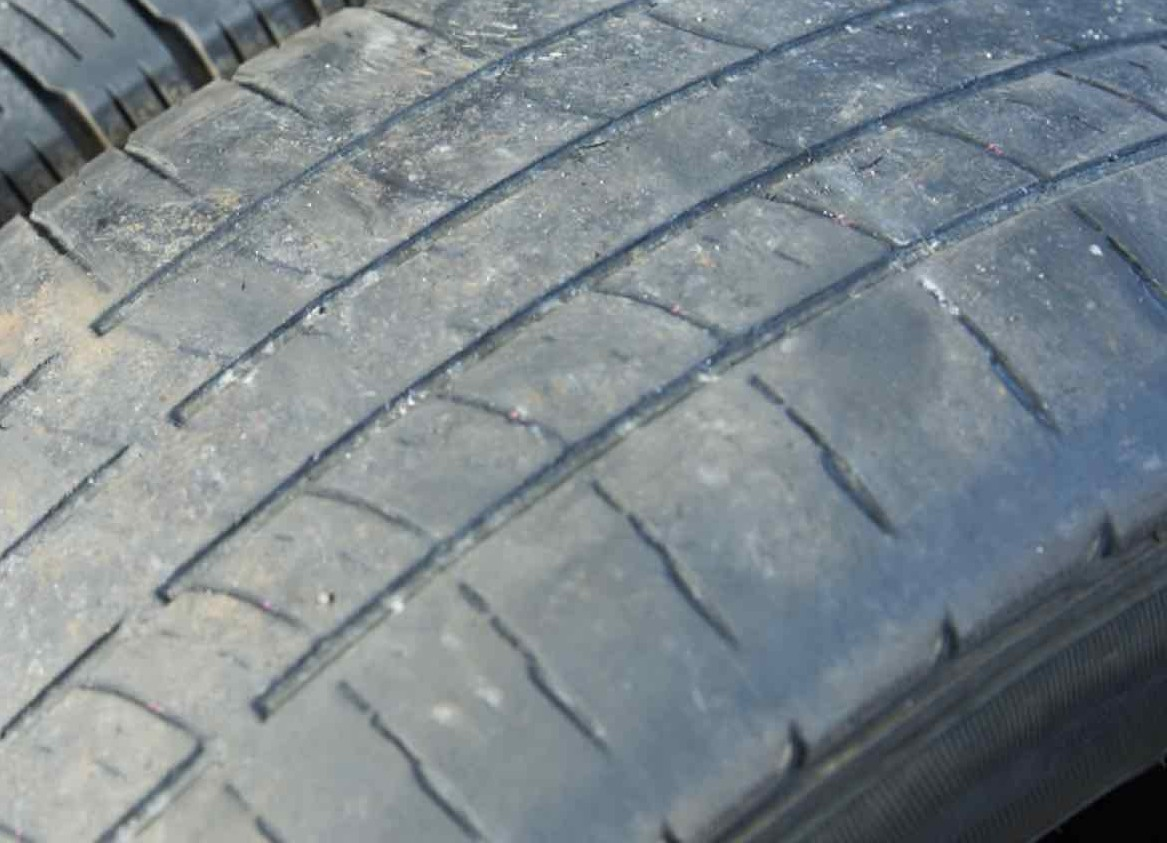

In [25]:
image